In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dotenv import load_dotenv
import ac3airborne
from ac3airborne.tools import flightphase
import os
import src
import typhon as ty
import datetime

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [2]:
# LOAD FLIGHT DATA
campaign = 'HALO-AC3'
platform = 'P5'
flight_nr = 'RF09'
flight_id = f'{campaign}_{platform}_{flight_nr}'
timeslot = '1055-1145'

cat, meta, credentials, kwds = src.get_ac3_meta()

flight = meta[campaign][platform][flight_id]
flight_query = flightphase.FlightPhaseFile(flight)

if timeslot is not None:
    date = meta[campaign][platform][flight_id]['date'].strftime("%Y%m%d")
    start_segment = datetime.datetime(
        int(date[0:4]),int(date[5:6]),int(date[6:8]), 
        int(timeslot[0:2]),int(timeslot[2:4]), 0)
    end_segment = datetime.datetime(
        int(date[0:4]),int(date[5:6]),int(date[6:8]), 
        int(timeslot[5:7]),int(timeslot[7:9]), 0)

try:
    miraca = cat[campaign][platform]['MiRAC-A'][flight_id](**credentials,storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))
except:
    miraca = cat[campaign][platform]['MiRAC-A'][flight_id](storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))
try:
    amsr2_sic = cat[campaign][platform]['AMSR2_SIC'][flight_id](**credentials,storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))
except:
    amsr2_sic = cat[campaign][platform]['AMSR2_SIC'][flight_id](storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))

ds_ctb = xr.open_dataset('/home/mech/projects/ac3/ac3airborne/airborne_lwp/data/'+ flight_id + '_clearsky_tb.nc')

In [3]:
lwp_p5_ds = xr.open_dataset(f'/net/secaire/mringel/data/lwp_retrieved/{flight_id}_lwp_v2.nc')
lwp_era5_ds = src.get_ERA5_along_P5(flight_id)
#lwp_aqua_ds = src.get_MODIS_along_P5(flight_id,satellite='aqua',mask_seaice=True)
lwp_terra_ds = src.get_MODIS_along_P5(flight_id,satellite='terra',mask_seaice=True)
lwp_amsr_ds = xr.open_dataset(f'/net/secaire/mringel/data/lwp_collocated/lwp_amsr2/{flight_id}_AMSR_lwp.nc')

if timeslot is not None:
    lwp_p5_ds = lwp_p5_ds.sel(time=slice(start_segment,end_segment))
    lwp_era5_ds = lwp_era5_ds.sel(time=slice(start_segment,end_segment))
    #lwp_aqua_ds = lwp_aqua_ds.sel(time=slice(start_segment,end_segment))
    lwp_terra_ds = lwp_terra_ds.sel(time=slice(start_segment,end_segment))
    lwp_amsr_ds = lwp_amsr_ds.sel(time=slice(start_segment,end_segment))
    amsr2_sic = amsr2_sic.sel(time=slice(start_segment,end_segment))
    miraca = miraca.sel(time=slice(start_segment,end_segment))
    ds_ctb = ds_ctb.sel(time=slice(start_segment,end_segment))

P5_timestamps = lwp_p5_ds.time.values
era5_timestamps = lwp_era5_ds.time.values
#aqua_timestamps = lwp_aqua_ds.time.values
terra_timestamps = lwp_terra_ds.time.values
amsr_timestamps = lwp_amsr_ds.time.values

lwp_p5 = lwp_p5_ds.lwp.values*1000
lwp_era5 = lwp_era5_ds.lwp.values*1000
#lwp_aqua = lwp_aqua_ds.lwp.values
lwp_terra = lwp_terra_ds.lwp.values
lwp_amsr = lwp_amsr_ds.lwp.values*1000

"""
mask = np.isin(era5_timestamps,P5_timestamps)
lwp_era5[mask==False] = np.nan

mask = np.isin(aqua_timestamps,P5_timestamps)
lwp_aqua[mask==False] = np.nan

mask = np.isin(terra_timestamps,P5_timestamps)
lwp_terra[mask==False] = np.nan

mask = np.isin(amsr_timestamps,P5_timestamps)
lwp_amsr[mask==False] = np.nan
"""

#lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_terra[lwp_terra==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan


In [4]:
manoeuvres = ['short_turn', 'long_turn', 'holding_pattern', 
              'small_ascent', 'major_ascent', 'small_descent',
              'major_descent', 'procedure_turn', 'large ascent',
              'large descent']
 

manoeuvre_segs = flight_query.selectKind(manoeuvres, invertSelection=False)
high_level_segs = flight_query.selectKind(['high_level'], invertSelection=False)

"\nif timeslot is None:\n    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',\n                bbox_inches='tight',\n                dpi=200)\nif timeslot is not None:\n    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}_{timeslot}.png',\n                bbox_inches='tight',\n                dpi=200)\n"

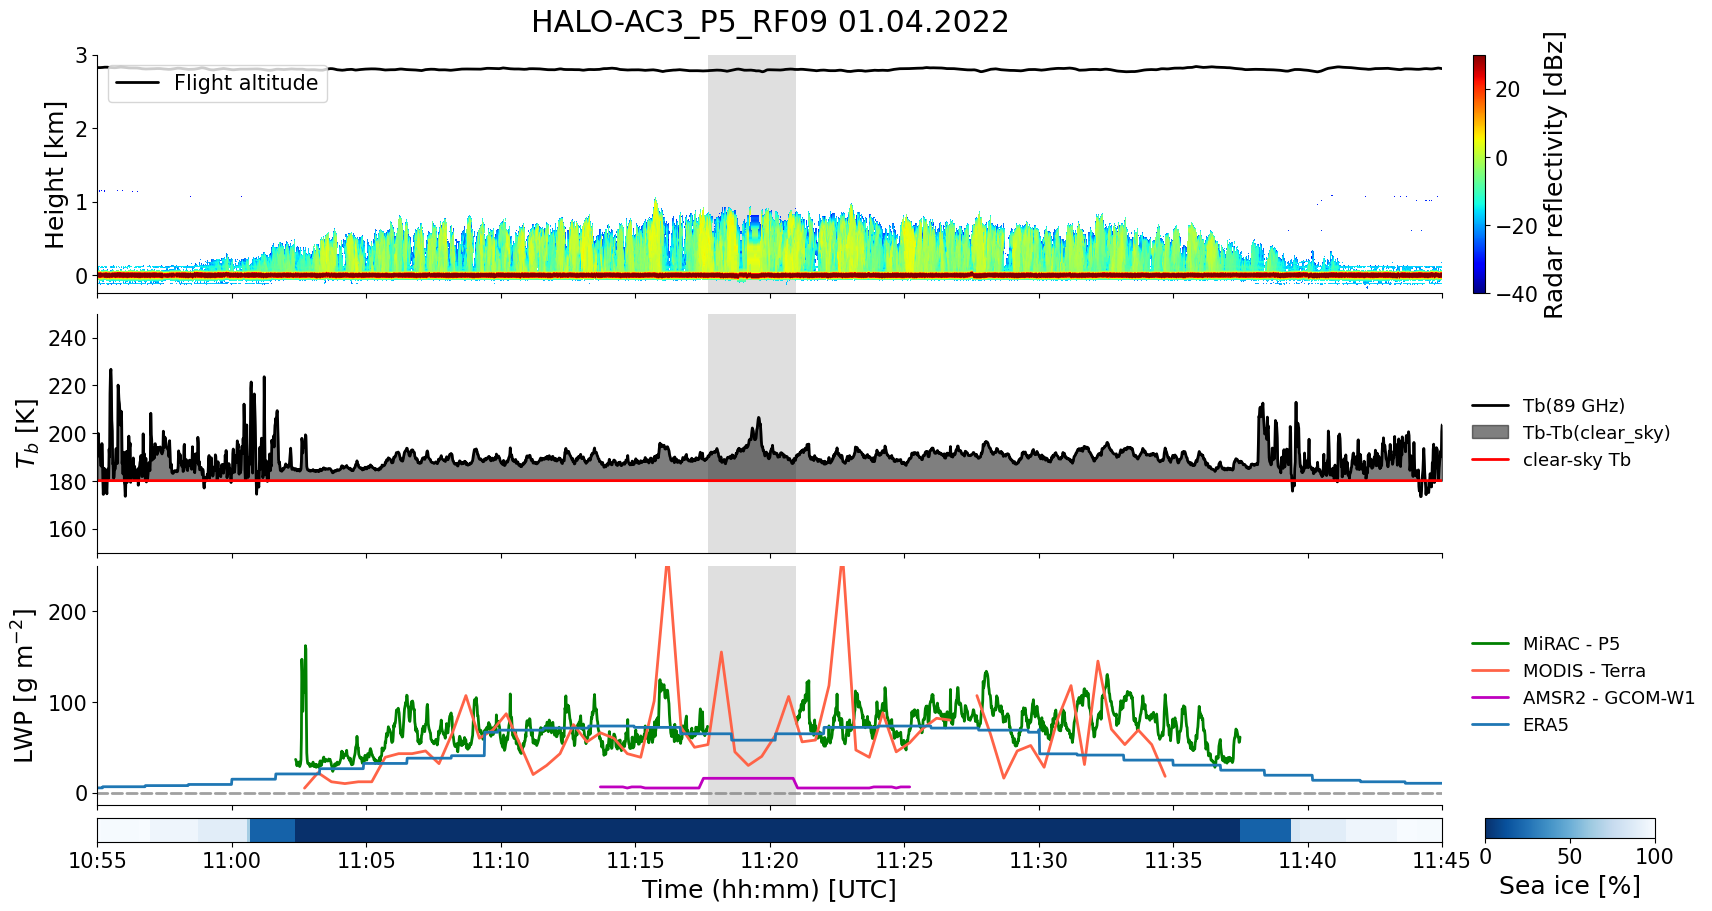

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(17,9), sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 0.1)))

# 1st: plot flight altitude and radar reflectivity

date = flight['date'].strftime("%d.%m.%Y")
fig.suptitle(flight_id+' '+date,x=0.45)

# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax1.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

# plot radar reflectivities
ax1.plot(miraca.time, miraca.alt*1e-3, label='Flight altitude', color='k')

im = ax1.pcolormesh(miraca.time, miraca.height*1e-3, 10*np.log10(miraca.Ze).T, vmin=-40, vmax=30, cmap='jet', shading='nearest')
fig.colorbar(im, ax=ax1, pad=-0.17, label='Radar reflectivity [dBz]')
ax1.set_ylim(-0.25, 3.)
ax1.set_ylabel('Height [km]')
legend = ax1.legend(frameon=True, loc='upper left')
frame = legend.get_frame()
frame.set_facecolor('white')

# 2nd: plot 89 GHz TBa

# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax2.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

#ax2.grid(0.15)
ax2.plot(miraca.time, miraca.tb, label='Tb(89 GHz)', color='k')
ax2.set_ylim(
    bottom=150, 
    top=250)
ax2.set_ylabel('$T_b$ [K]')

ax2.fill_between(miraca.time,ds_ctb.ctb,miraca.tb,color='black',alpha=0.5,label='Tb-Tb(clear_sky)')

ax2.plot(ds_ctb.time,ds_ctb.ctb,color='red',label='clear-sky Tb')

#ax2.legend(frameon=False, loc='upper left')
ax2.legend(frameon=False,
           bbox_to_anchor=(1.01, 0.5), 
           loc='center left',
           fontsize=13)

# add NaN values for missing timestamps 
#lwp_p5 = np.empty(len(miraca.time.values))
#for i, ts in enumerate(miraca.time.values):
#    try:
#        lwp_p5[i] = lwp_p5_ds.sel(time=ts).lwp.values
#    except:
#        lwp_p5[i] = np.nan

# 3rd: plot LWP
        
# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax3.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

#ax3.grid(0.15)
ax3.axhline(y=0,linestyle='dashed',color='gray',alpha=0.75)
ax3.plot(lwp_p5_ds.time,lwp_p5_ds.lwp*1000,color='green',label='MiRAC - P5')
#ax3.plot(aqua_timestamps,lwp_aqua,color='darkred',label='MODIS - Aqua')
ax3.plot(terra_timestamps,lwp_terra,color='tomato',label='MODIS - Terra')
ax3.plot(amsr_timestamps,lwp_amsr,color='m',label='AMSR2 - GCOM-W1')

ax3.plot(era5_timestamps,lwp_era5,linestyle='-',label='ERA5',color='C0')
ax3.set_ylabel('LWP [g m$^{-2}$]')
ax3.set_ylim(
    #bottom=-50,
    top=250
    )
ax3.legend(frameon=False,
           bbox_to_anchor=(1.01, 0.5), 
           loc='center left',
           ncol=1,
           fontsize=13)

# plot AMSR2 sea ice concentration
im = ax4.pcolormesh(amsr2_sic.time,
               np.array([0, 1]),
               np.array([amsr2_sic.sic,amsr2_sic.sic]), cmap='Blues_r', vmin=0, vmax=100,
               shading='auto')
cax = fig.add_axes([0.87, 0.075, 0.1, ax4.get_position().height])
fig.colorbar(im, cax=cax, orientation='horizontal', label='Sea ice [%]')
ax4.tick_params(axis='y', labelleft=False, left=False)
ax4.spines[:].set_visible(True)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.set_xlabel('Time (hh:mm) [UTC]')

#plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',
#                    bbox_inches='tight',
#                    dpi=200)

"""
if timeslot is None:
    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',
                bbox_inches='tight',
                dpi=200)
if timeslot is not None:
    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}_{timeslot}.png',
                bbox_inches='tight',
                dpi=200)
"""

"\nif timeslot is None:\n    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',\n                bbox_inches='tight',\n                dpi=200)\nif timeslot is not None:\n    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}_{timeslot}.png',\n                bbox_inches='tight',\n                dpi=200)\n"

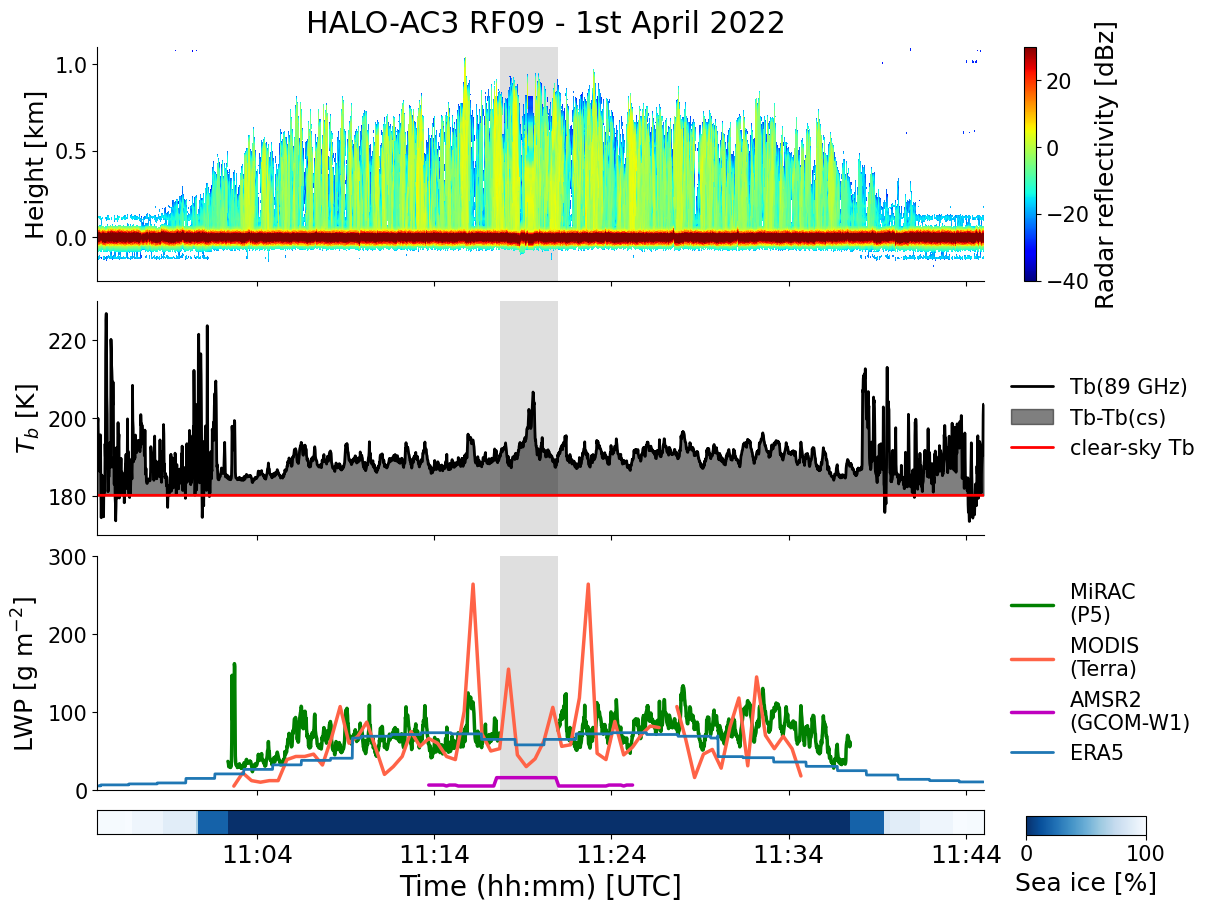

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,9), sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 0.1)))

# 1st: plot flight altitude and radar reflectivity

date = flight['date'].strftime("%d.%m.%Y")
fig.suptitle('HALO-AC3 RF09 - 1st April 2022',x=0.45)

# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax1.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

# plot radar reflectivities
ax1.plot(miraca.time, miraca.alt*1e-3, label='Flight altitude', color='k')

im = ax1.pcolormesh(miraca.time, miraca.height*1e-3, 10*np.log10(miraca.Ze).T, vmin=-40, vmax=30, cmap='jet', shading='nearest')
fig.colorbar(im, ax=ax1, pad=-0.2, label='Radar reflectivity [dBz]')
ax1.set_ylim(-0.25, 1.1)
ax1.set_ylabel('Height [km]')
#legend = ax1.legend(frameon=True, loc='upper left')
#frame = legend.get_frame()
#frame.set_facecolor('white')

# 2nd: plot 89 GHz TBa

# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax2.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

#ax2.grid(0.15)
ax2.plot(miraca.time, miraca.tb, label='Tb(89 GHz)', color='k')
ax2.set_ylim(
    bottom=170, 
    top=230)
ax2.set_ylabel('$T_b$ [K]')

ax2.fill_between(miraca.time,ds_ctb.ctb,miraca.tb,color='black',alpha=0.5,label='Tb-Tb(cs)')

ax2.plot(ds_ctb.time,ds_ctb.ctb,color='red',label='clear-sky Tb')

#ax2.legend(frameon=False, loc='upper left')
ax2.legend(frameon=False,
           bbox_to_anchor=(1.01, 0.5), 
           loc='center left',
           fontsize=15)
        
# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax3.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

#ax3.grid(0.15)
#ax3.axhline(y=0,linestyle='dashed',color='gray',alpha=0.75)
ax3.plot(lwp_p5_ds.time,lwp_p5_ds.lwp*1000,linewidth=2.5,color='green',label='MiRAC\n(P5)')
#ax3.plot(aqua_timestamps,lwp_aqua,color='darkred',label='MODIS - Aqua')
ax3.plot(terra_timestamps,lwp_terra,color='tomato',linewidth=2.5,label='MODIS\n(Terra)')
ax3.plot(amsr_timestamps,lwp_amsr,color='m',linewidth=2.5,label='AMSR2\n(GCOM-W1)')

ax3.plot(era5_timestamps,lwp_era5,linestyle='-',label='ERA5',color='C0')
ax3.set_ylabel('LWP [g m$^{-2}$]')
ax3.set_ylim(
    bottom=0,
    top=300
    )
ax3.legend(frameon=False,
           bbox_to_anchor=(1.01, 0.5), 
           loc='center left',
           ncol=1,
           fontsize=15)

# plot AMSR2 sea ice concentration
im = ax4.pcolormesh(amsr2_sic.time,
               np.array([0, 1]),
               np.array([amsr2_sic.sic,amsr2_sic.sic]), cmap='Blues_r', vmin=0, vmax=100,
               shading='auto')
cax = fig.add_axes([0.85, 0.078, 0.1, ax4.get_position().height])
fig.colorbar(im, cax=cax, orientation='horizontal', label='Sea ice [%]')
ax4.tick_params(axis='y', labelleft=False, left=False)
ax4.spines[:].set_visible(True)
ax4.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.set_xlabel('Time (hh:mm) [UTC]',fontsize=20)
ax4.tick_params(axis="both", labelsize=18) 

plt.savefig(f'/home/mringel/lwp_project/figures/figures4poster/Quicklook_{flight_id}_{timeslot}.png',
                bbox_inches='tight',
                dpi=200)

"""
if timeslot is None:
    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',
                bbox_inches='tight',
                dpi=200)
if timeslot is not None:
    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}_{timeslot}.png',
                bbox_inches='tight',
                dpi=200)
"""

"\nif timeslot is None:\n    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',\n                bbox_inches='tight',\n                dpi=200)\nif timeslot is not None:\n    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}_{timeslot}.png',\n                bbox_inches='tight',\n                dpi=200)\n"

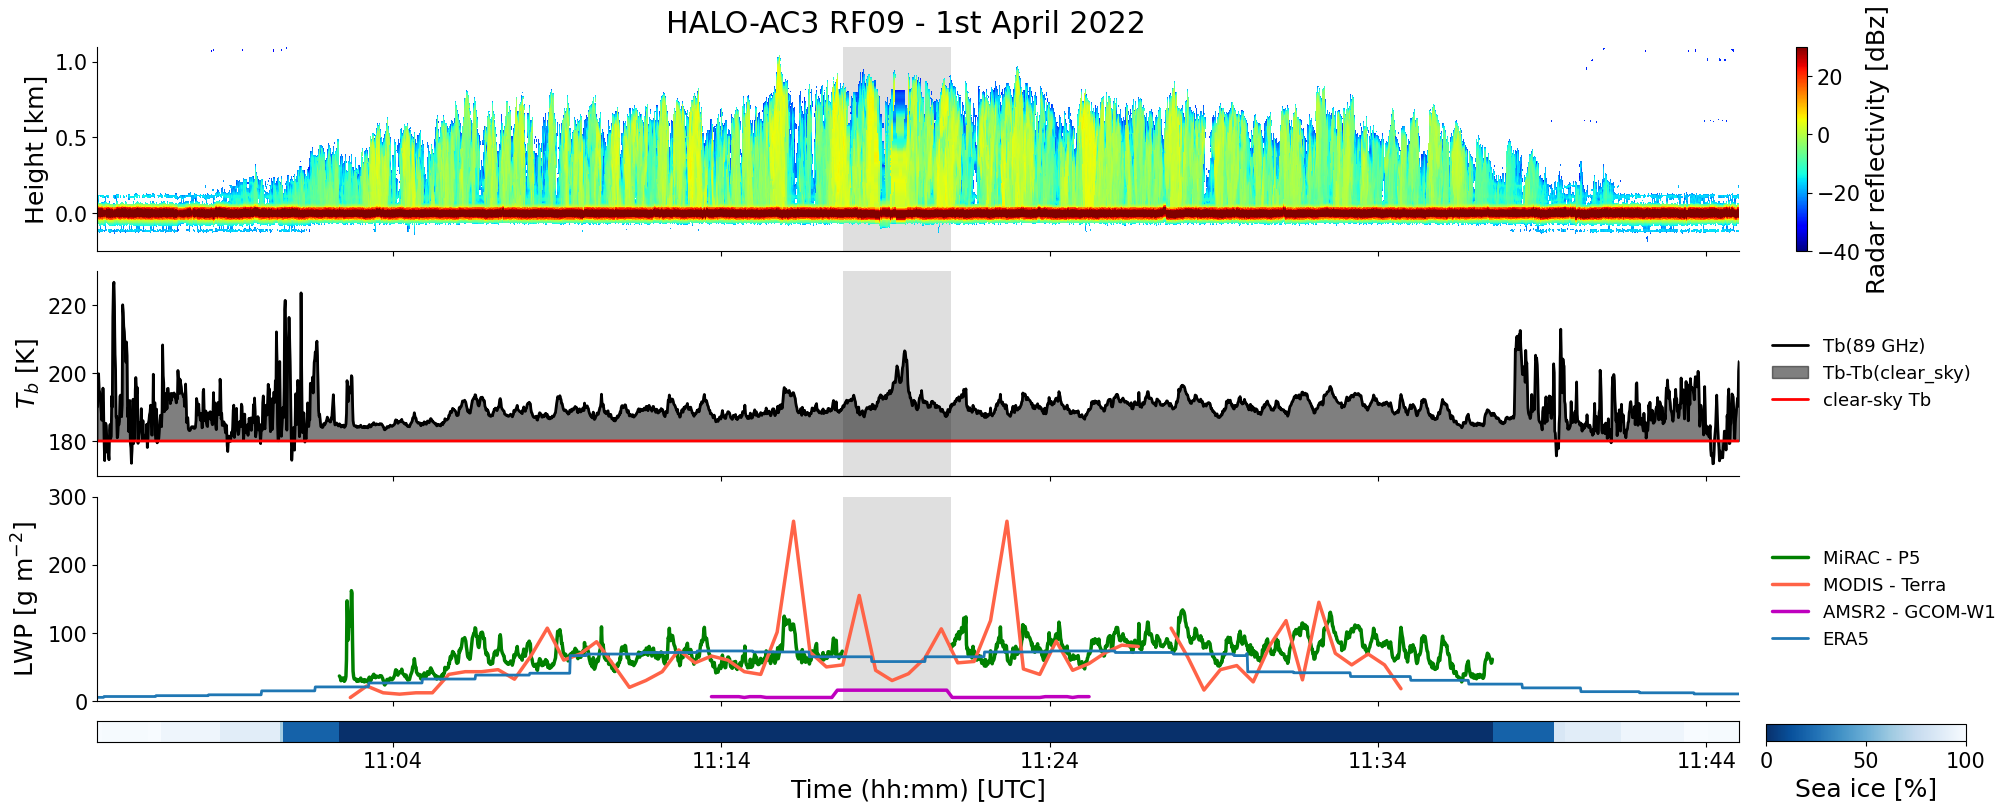

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 0.1)))

# 1st: plot flight altitude and radar reflectivity

date = flight['date'].strftime("%d.%m.%Y")
fig.suptitle('HALO-AC3 RF09 - 1st April 2022',x=0.45)

# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax1.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

# plot radar reflectivities
ax1.plot(miraca.time, miraca.alt*1e-3, label='Flight altitude', color='k')

im = ax1.pcolormesh(miraca.time, miraca.height*1e-3, 10*np.log10(miraca.Ze).T, vmin=-40, vmax=30, cmap='jet', shading='nearest')
fig.colorbar(im, ax=ax1, pad=-0.125, label='Radar reflectivity [dBz]')
ax1.set_ylim(-0.25, 1.1)
ax1.set_ylabel('Height [km]')
#legend = ax1.legend(frameon=True, loc='upper left')
#frame = legend.get_frame()
#frame.set_facecolor('white')

# 2nd: plot 89 GHz TBa

# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax2.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

#ax2.grid(0.15)
ax2.plot(miraca.time, miraca.tb, label='Tb(89 GHz)', color='k')
ax2.set_ylim(
    bottom=170, 
    top=230)
ax2.set_ylabel('$T_b$ [K]')

ax2.fill_between(miraca.time,ds_ctb.ctb,miraca.tb,color='black',alpha=0.5,label='Tb-Tb(clear_sky)')

ax2.plot(ds_ctb.time,ds_ctb.ctb,color='red',label='clear-sky Tb')

#ax2.legend(frameon=False, loc='upper left')
ax2.legend(frameon=False,
           bbox_to_anchor=(1.01, 0.5), 
           loc='center left',
           fontsize=13)
        
# plot flight manoveurs or high level sections as greyscale
for q in manoeuvre_segs:
    ax3.axvspan(q['start'],q['end'],facecolor='grey',alpha=0.25)

#ax3.grid(0.15)
#ax3.axhline(y=0,linestyle='dashed',color='gray',alpha=0.75)
ax3.plot(lwp_p5_ds.time,lwp_p5_ds.lwp*1000,linewidth=2.5,color='green',label='MiRAC - P5')
#ax3.plot(aqua_timestamps,lwp_aqua,color='darkred',label='MODIS - Aqua')
ax3.plot(terra_timestamps,lwp_terra,color='tomato',linewidth=2.5,label='MODIS - Terra')
ax3.plot(amsr_timestamps,lwp_amsr,color='m',linewidth=2.5,label='AMSR2 - GCOM-W1')

ax3.plot(era5_timestamps,lwp_era5,linestyle='-',label='ERA5',color='C0')
ax3.set_ylabel('LWP [g m$^{-2}$]')
ax3.set_ylim(
    bottom=0,
    top=300
    )
ax3.legend(frameon=False,
           bbox_to_anchor=(1.01, 0.5), 
           loc='center left',
           ncol=1,
           fontsize=13)

# plot AMSR2 sea ice concentration
im = ax4.pcolormesh(amsr2_sic.time,
               np.array([0, 1]),
               np.array([amsr2_sic.sic,amsr2_sic.sic]), cmap='Blues_r', vmin=0, vmax=100,
               shading='auto')
cax = fig.add_axes([0.88, 0.08, 0.1, ax4.get_position().height])
fig.colorbar(im, cax=cax, orientation='horizontal', label='Sea ice [%]')
ax4.tick_params(axis='y', labelleft=False, left=False)
ax4.spines[:].set_visible(True)
ax4.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.set_xlabel('Time (hh:mm) [UTC]')

plt.savefig(f'/home/mringel/lwp_project/figures/figures4poster/Quicklook_{flight_id}_{timeslot}_v2.png',
                bbox_inches='tight',
                dpi=200)

"""
if timeslot is None:
    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}.png',
                bbox_inches='tight',
                dpi=200)
if timeslot is not None:
    plt.savefig(f'/home/mringel/lwp_project/figures/quicklooks/Quicklook_{flight_id}_{timeslot}.png',
                bbox_inches='tight',
                dpi=200)
"""